In [166]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

torch.manual_seed(5)

# Import Images and Image Processing

In [168]:
filepath = os.getcwd()

image_dir_p1 = os.path.join(filepath, "HAM10000_img/HAM10000_images_part_1")
image_dir_p2 = os.path.join(filepath, "HAM10000_img/HAM10000_images_part_2")
image_dir_p3 = os.path.join(filepath, "HAM10000_img/HAM10000_segmentations_lesion_tschandl/HAM10000_segmentations_lesion_tschandl")

image_list = []
name_list = []
seg_list = []
segname_list = []

#Load Images P1(450, 600, 3)
for images in os.listdir(image_dir_p1):
    image = os.path.join(image_dir_p1, images)
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    name_list.append(images[:-4])
    image_list.append(image)

#Load Images P2(450, 600, 3)
for images in os.listdir(image_dir_p2):
    image = os.path.join(image_dir_p2, images)
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    name_list.append(images[:-4])
    image_list.append(image)


# Load Segmentation Images
for images in os.listdir(image_dir_p3):
    image = os.path.join(image_dir_p3, images)
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (224, 224))
    
    segname_list.append(images[:-17])
    seg_list.append(image)

In [170]:
#Normalize image_list (0-255) to (0-1)
image_list = (np.array(image_list).astype(float)/255.0)

In [174]:
#Compute Image Mean for later Data Augmentation

#Compute mean for each image (10015, 224, 224, 3) -> (10015, 3)
img_mean = image_list.mean(axis=(1,2))

#Compute mean for all images on RGB Channel
norm_mean = img_mean.mean(axis = 0)
#Compute std dev for all images on RGB Channel
norm_std = image_list.reshape(10015*224*224, 3).std(axis = 0)
print(norm_mean)
print(norm_std)


[0.76303759 0.54564515 0.57004444]
[0.14092787 0.15261437 0.16997586]


In [176]:
#Image list should be (10015, 224, 224)
print(np.array(image_list).shape)
#Name List should be (10015)
print(np.array(name_list).shape)
#Binary Segmentation Mask should be (10015, 224, 224)
print(np.array(seg_list).shape)

(10015, 224, 224, 3)
(10015,)
(10015, 224, 224)


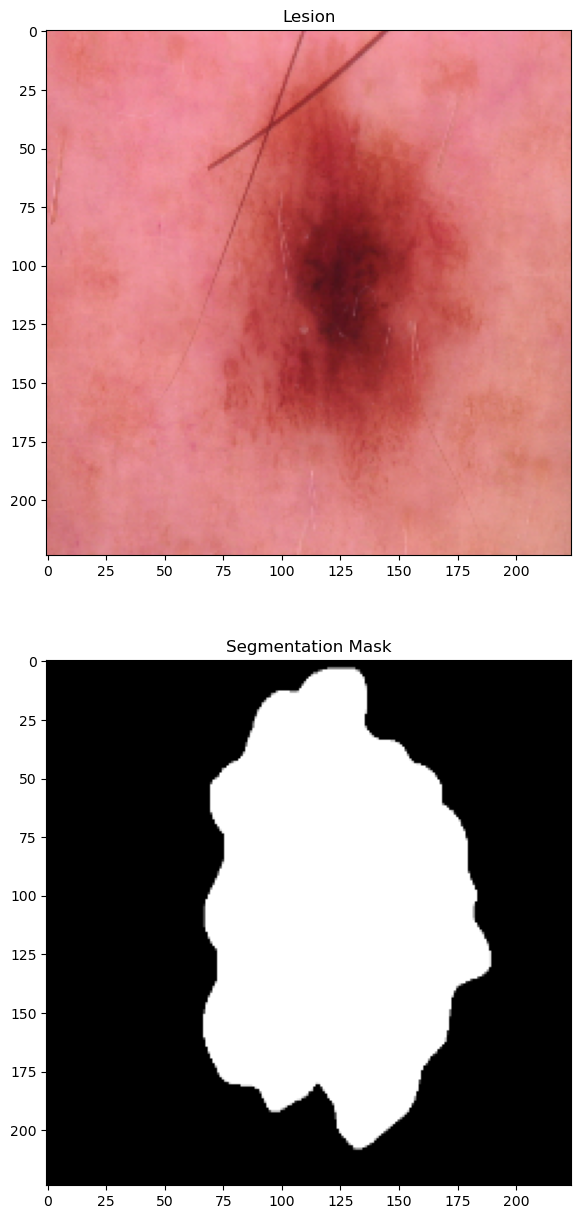

In [178]:
fig, ax = plt.subplots(2, figsize=(8, 15))
ax[0].imshow(image_list[0])
ax[0].set_title("Lesion")
ax[1].imshow(seg_list[0], cmap = "gray")
ax[1].set_title("Segmentation Mask")
plt.show()

# Classes

In [181]:
def transformToTensor(X):
    ret_list = []
    transform = transforms.Compose([
                transforms.ToTensor()
              ])
    for image in X:
      ret_list.append(transform(np.array(image)))

    return torch.tensor(np.array(ret_list), dtype=torch.float32)


def weight_accuracy(predicted_y, true_y, weight):
    pred_y, tar_y, w = np.array(predicted_y), np.array(true_y), np.array(weight)
    return np.sum((pred_y == tar_y) * w.reshape(w.size)) / np.sum(w)

def num_accuracy(predicted_y, true_y):
    pred_y, tar_y = np.array(predicted_y), np.array(true_y)
    return np.sum((pred_y == tar_y)) / len(pred_y)




# Process images/data 

In [184]:
image_metadata =  os.path.join(filepath, "HAM10000_img/HAM10000_metadata.csv")
image_metadata = pd.read_csv(image_metadata)
print("Metadata shape", image_metadata.shape)
print(image_metadata.head())

Metadata shape (10015, 7)
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


## Convert Image and Segmentation Masks to Pandas dataframe using image_id as key

In [187]:
#(10015, 450, 600, 3)
image_dataframe = pd.DataFrame({'image_id': name_list, 'data': list(image_list)})
seg_dataframe = pd.DataFrame({'image_id': segname_list, 'segdata': seg_list})

print("Image dataframe", image_dataframe.head())
print("Segmentation Mask dataframe", seg_dataframe.head())

Image dataframe        image_id                                               data
0  ISIC_0024306  [[[0.8745098039215686, 0.5058823529411764, 0.4...
1  ISIC_0024307  [[[0.8431372549019608, 0.4823529411764706, 0.5...
2  ISIC_0024308  [[[0.9686274509803922, 0.6745098039215687, 0.7...
3  ISIC_0024309  [[[0.8235294117647058, 0.47843137254901963, 0....
4  ISIC_0024310  [[[0.27450980392156865, 0.13333333333333333, 0...
Segmentation Mask dataframe        image_id                                            segdata
0  ISIC_0024306  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  ISIC_0024307  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2  ISIC_0024308  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  ISIC_0024309  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  ISIC_0024310  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


In [189]:
#Clear memory
name_list =[]
image_list =[]
segname_list =[]
seg_list = []

## Compute Class Weights for Disproportionate classes

In [192]:
def compute_class_weights(data):
    #Weights
    temp = pd.Categorical(data)
    values = temp.value_counts()
    
    weight_list = []
    label_list = []
    for label in temp.categories:
        label_list.append(label)
        weight_list.append(len(data)/(7*values[label]))
        
    weighted = pd.DataFrame({'dx': label_list, 'weights':weight_list})
    return weighted

In [194]:
#We have a huge class imbalance, we must correct it by data augmenting all classes that aren't "nv"
weighted = compute_class_weights(image_metadata["dx"])
print(weighted)

      dx    weights
0  akiec   4.375273
1    bcc   2.783491
2    bkl   1.301833
3     df  12.440994
4    mel   1.285458
5     nv   0.213380
6   vasc  10.075453


## Merge Image Dataframe and Segmentation Dataframe with Class Weights

In [197]:
labels = image_metadata[["image_id", "dx"]]

#Merge dataframes
fin_dataframe = pd.merge(image_dataframe, labels)
fin_dataframe = pd.merge(fin_dataframe, seg_dataframe)

#(Image_id, Image, Class, Segmentation Mask, Class Weights)
print(fin_dataframe.head())

       image_id                                               data   dx  \
0  ISIC_0024306  [[[0.8745098039215686, 0.5058823529411764, 0.4...   nv   
1  ISIC_0024307  [[[0.8431372549019608, 0.4823529411764706, 0.5...   nv   
2  ISIC_0024308  [[[0.9686274509803922, 0.6745098039215687, 0.7...   nv   
3  ISIC_0024309  [[[0.8235294117647058, 0.47843137254901963, 0....   nv   
4  ISIC_0024310  [[[0.27450980392156865, 0.13333333333333333, 0...  mel   

                                             segdata  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  


## Mask Images with Segmentation Mask

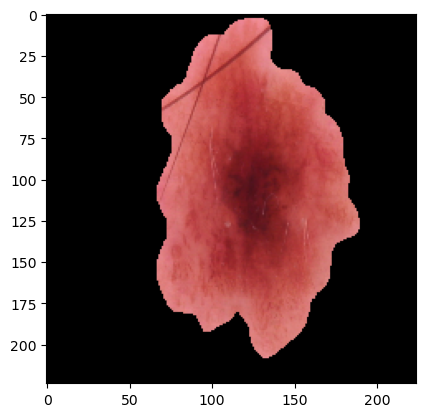

In [34]:
#Mask images
for index, row in fin_dataframe.iterrows():
    fin_dataframe.at[index, 'data'] = cv2.bitwise_and(row['data'], row['data'], mask=row['segdata'])

plt.figure()
plt.imshow(fin_dataframe.iloc[0]['data'])
plt.show()

## 80:20 Split

In [199]:
#80:20 Split
train_dataset, valid_dataset = train_test_split(fin_dataframe,  test_size = .2, random_state = 5, stratify = fin_dataframe["dx"])
train_dataset, valid_dataset = train_dataset.reset_index(drop=True), valid_dataset.reset_index(drop=True)
print(train_dataset.shape, valid_dataset.shape)
print(train_dataset["dx"].value_counts())
print(valid_dataset["dx"].value_counts())


(8012, 4) (2003, 4)
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
dx
nv       1341
mel       223
bkl       220
bcc       103
akiec      65
vasc       28
df         23
Name: count, dtype: int64


## Data Augmentation and Oversampling for Class Imbalance

In [202]:
imbalance_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.25),
    transforms.ToTensor(), 
    transforms.Normalize(norm_mean, norm_std)
])
oversample = {"mel": 5, "bkl":5, "bcc":12, "akiec":20, "vasc": 45, "df":55, "nv":0}

for i in range(len(train_dataset)):
    #Data Augmentation
    # duplicate.at[i, "data"] = (imbalance_transform(Image.fromarray((duplicate.loc[i, "data"]*255).astype(np.uint8))) / 255.0).permute(1, 2, 0).cpu().detach().numpy()
    
    for j in range(oversample[train_dataset.at[i, "dx"]]):
        #Oversampling until class samples are similar in sice
        train_dataset = pd.concat([train_dataset, train_dataset.iloc[[i]]], ignore_index = True)



In [203]:
#Counts of each duplicate
print(train_dataset.shape)
print(train_dataset["dx"].value_counts())


(37219, 4)
dx
akiec    5502
nv       5364
bcc      5343
mel      5340
bkl      5274
vasc     5244
df       5152
Name: count, dtype: int64


In [204]:
#Merge Duplicates with Original Training data
# print(train_dataset.shape, duplicate.shape)
# train_dataset = pd.concat([duplicate, train_dataset]).reset_index(drop=True)
# print("Combined shape:", train_dataset.shape)

## Recompute Class Weights

In [209]:
#Compute Weights
weighted = compute_class_weights(train_dataset["dx"])
print(weighted)

      dx   weights
0  akiec  0.966376
1    bcc  0.995134
2    bkl  1.008153
3     df  1.032026
4    mel  0.995693
5     nv  0.991238
6   vasc  1.013921


In [211]:
train_dataset = pd.merge(train_dataset, weighted)
valid_dataset = pd.merge(valid_dataset, weighted)

# Load into Dataloaders

In [214]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(), 
    transforms.Normalize(norm_mean, norm_std)
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

In [216]:
class Melanoma_Dataset(Dataset):
    def __init__(self, df, target, transform = None):
        super(Melanoma_Dataset, self).__init__()
        self.df = df
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        '''Return rows of panda columns'''
        cur_img = self.df.loc[idx, "data"]

        temp_list = np.zeros(7)
        temp_list[int(self.target[idx])] = 1
        cur_target = torch.tensor(temp_list, dtype=torch.float32)

        cur_weights = self.df.loc[idx, "weights"]
        cur_weights = torch.tensor(cur_weights.tolist(), dtype=torch.float32)

        if(self.transform):
            cur_img = self.transform(Image.fromarray((cur_img*255.0).astype(np.uint8)))/255.0
        else:
            cur_img = torch.tensor(cur_img.tolist(), dtype=torch.float32)
            

        return cur_img, cur_target, cur_weights

## Shuffle Data

In [219]:
#Shuffle Data
train_dataset = train_dataset.sample(frac=1,random_state=5,replace=False).reset_index(drop=True)
print(train_dataset.head())

       image_id                                               data   dx  \
0  ISIC_0030319  [[[0.5647058823529412, 0.4392156862745098, 0.4...  bkl   
1  ISIC_0032287  [[[0.5647058823529412, 0.4549019607843137, 0.4...  mel   
2  ISIC_0033808  [[[0.6941176470588235, 0.6274509803921569, 0.7...   df   
3  ISIC_0029170  [[[0.7058823529411765, 0.5372549019607843, 0.5...  mel   
4  ISIC_0027613  [[[0.10980392156862745, 0.06666666666666667, 0...   df   

                                             segdata   weights  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  1.008153  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  0.995693  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  1.032026  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  0.995693  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  1.032026  


## Extract Unique Class Weights for training

In [222]:
all_weights = torch.tensor(weighted["weights"], dtype=torch.float32)
print("All weights:", all_weights)

All weights: tensor([0.9664, 0.9951, 1.0082, 1.0320, 0.9957, 0.9912, 1.0139])


## 80:20 Datasplit

In [225]:
#80:20 datasplit with training_data oversampled and augmented
print(train_dataset.shape, valid_dataset.shape)

train_dataset = Melanoma_Dataset(train_dataset, pd.Categorical(train_dataset["dx"]).codes, train_transform)
valid_dataset = Melanoma_Dataset(valid_dataset, pd.Categorical(valid_dataset["dx"]).codes, val_transform)

(37219, 5) (2003, 5)


## Dataloader

In [228]:
train_dataset = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_dataset = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
X,Y,W = next(iter(train_dataset))
print(X.shape, Y.shape, W.shape)

print(len(valid_dataset))
X,Y, W = next(iter(valid_dataset))
print(X.shape, Y.shape, W.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 7]) torch.Size([32])
63
torch.Size([32, 3, 224, 224]) torch.Size([32, 7]) torch.Size([32])


# Resnet50 Model

In [235]:
resnet50 = torchvision.models.resnet50(weights='DEFAULT')
resnet50.fc = nn.Linear(resnet50.fc.in_features, 7)

#Freeze the pre-trained layers
# for parameter in resnet50.parameters():
#     parameter.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet50.parameters(), lr=0.0001)

# Unfreeze last few parameters
# for parameter in resnet50.layer4.parameters():
#     parameter.requires_grad = True

# for parameter in resnet50.fc.parameters():
#     parameter.requires_grad = True

for name, parameter in resnet50.named_parameters():
    if(parameter.requires_grad):
        print("not frozen", name)
    else:
        print("frozen", name)

conf_list = []
precise_list = []
recall_list = []
f1_list = []
weightacc_list = []
numacc_list = []


not frozen conv1.weight
not frozen bn1.weight
not frozen bn1.bias
not frozen layer1.0.conv1.weight
not frozen layer1.0.bn1.weight
not frozen layer1.0.bn1.bias
not frozen layer1.0.conv2.weight
not frozen layer1.0.bn2.weight
not frozen layer1.0.bn2.bias
not frozen layer1.0.conv3.weight
not frozen layer1.0.bn3.weight
not frozen layer1.0.bn3.bias
not frozen layer1.0.downsample.0.weight
not frozen layer1.0.downsample.1.weight
not frozen layer1.0.downsample.1.bias
not frozen layer1.1.conv1.weight
not frozen layer1.1.bn1.weight
not frozen layer1.1.bn1.bias
not frozen layer1.1.conv2.weight
not frozen layer1.1.bn2.weight
not frozen layer1.1.bn2.bias
not frozen layer1.1.conv3.weight
not frozen layer1.1.bn3.weight
not frozen layer1.1.bn3.bias
not frozen layer1.2.conv1.weight
not frozen layer1.2.bn1.weight
not frozen layer1.2.bn1.bias
not frozen layer1.2.conv2.weight
not frozen layer1.2.bn2.weight
not frozen layer1.2.bn2.bias
not frozen layer1.2.conv3.weight
not frozen layer1.2.bn3.weight
not froz

In [237]:
num_epochs = 20
total_step = len(train_dataset)
for epoch in range(num_epochs):
    resnet50.train()
    for i, (X, Y, W) in enumerate(train_dataset):
        # Forward pass
        output = resnet50(X)
        criterion.weight = all_weights
        loss = criterion(output, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
               .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    y_pred_list = np.empty(0)
    y_target_list = np.empty(0)
    y_weight_list = np.empty(0)
    resnet50.eval()
    with torch.no_grad():
        for i, (X, Y, W) in enumerate(valid_dataset):
            output = resnet50(X)

            y_pred_list = np.concatenate((y_pred_list, (np.argmax(np.array(output.cpu().data), axis = 1))), axis = 0)

            y_target_list = np.concatenate((y_target_list, (np.argmax(np.array(Y.cpu().data), axis=1))), axis= 0)

            y_weight_list = np.concatenate((y_weight_list, np.array(W.cpu().data)), axis=0)



    conf_list.append(confusion_matrix(y_pred_list,y_target_list))
    precise_list.append(precision_score(y_pred_list,y_target_list, average="weighted"))
    recall_list.append(recall_score(y_pred_list,y_target_list, average="weighted"))
    f1_list.append(f1_score(y_pred_list,y_target_list, average="weighted"))
    weightacc_list.append(weight_accuracy(y_pred_list,y_target_list, y_weight_list))
    numacc_list.append(num_accuracy(y_pred_list,y_target_list))

    print("Validation Weighted Accuracy:", weight_accuracy(y_pred_list,y_target_list, y_weight_list))
    print("Validation Num Accuracy:", num_accuracy(y_pred_list,y_target_list))


Epoch [1/20], Step [1/1164], Loss: 1.9896
Epoch [1/20], Step [2/1164], Loss: 1.9809
Epoch [1/20], Step [3/1164], Loss: 1.9343
Epoch [1/20], Step [4/1164], Loss: 1.9088
Epoch [1/20], Step [5/1164], Loss: 1.8942
Epoch [1/20], Step [6/1164], Loss: 1.9079
Epoch [1/20], Step [7/1164], Loss: 1.9110
Epoch [1/20], Step [8/1164], Loss: 1.8840
Epoch [1/20], Step [9/1164], Loss: 1.8831
Epoch [1/20], Step [10/1164], Loss: 1.8814
Epoch [1/20], Step [11/1164], Loss: 1.8183
Epoch [1/20], Step [12/1164], Loss: 1.8830
Epoch [1/20], Step [13/1164], Loss: 1.8978
Epoch [1/20], Step [14/1164], Loss: 1.8874
Epoch [1/20], Step [15/1164], Loss: 1.8954
Epoch [1/20], Step [16/1164], Loss: 1.8141
Epoch [1/20], Step [17/1164], Loss: 1.8002
Epoch [1/20], Step [18/1164], Loss: 1.7854
Epoch [1/20], Step [19/1164], Loss: 1.7959
Epoch [1/20], Step [20/1164], Loss: 1.7265
Epoch [1/20], Step [21/1164], Loss: 1.8233
Epoch [1/20], Step [22/1164], Loss: 1.6933
Epoch [1/20], Step [23/1164], Loss: 1.7152
Epoch [1/20], Step [

In [162]:
print(confusion_matrix(y_pred_list,y_target_list))

[[  48    1    8    0    3    0    0]
 [   6   87    5    0    2    4    0]
 [   5    7  178    1   21   47    0]
 [   3    2    2   20    2    4    0]
 [   1    3   17    0  167   64    0]
 [   2    3   10    2   28 1219    1]
 [   0    0    0    0    0    3   27]]


In [71]:
y_pred_list = np.empty(0)
y_target_list = np.empty(0)
y_weight_list = np.empty(0)
resnet50.eval()
with torch.no_grad():
    for i, (X, Y, W) in enumerate(train_dataset):
        output = resnet50(X)

        y_pred_list = np.concatenate((y_pred_list, (np.argmax(np.array(output.cpu().data), axis = 1))), axis = 0)

        y_target_list = np.concatenate((y_target_list, (np.argmax(np.array(Y.cpu().data), axis=1))), axis= 0)

        y_weight_list = np.concatenate((y_weight_list, np.array(W.cpu().data)), axis=0)
print("Train Weighted Accuracy:", weight_accuracy(y_pred_list,y_target_list, y_weight_list))
print("Train Num Accuracy:", num_accuracy(y_pred_list,y_target_list))

Train Weighted Accuracy: 0.8915690365092396
Train Num Accuracy: 0.8614649681528662


In [164]:
print(weightacc_list)
print(numacc_list)

[0.78897847383259, 0.8499251048975186, 0.8724611525420752, 0.8793574010407589, 0.8860324210446666, 0.8861891145442118, 0.871645385326758]
[0.7888167748377434, 0.8502246630054917, 0.872690963554668, 0.8796804792810784, 0.8861707438841737, 0.8866699950074888, 0.8716924613080379]


In [239]:
print(weightacc_list)
print(numacc_list)

[0.8380488355546334, 0.8476391441233402, 0.8556351270636778, 0.8717989864871428, 0.8749414877485141, 0.8751354353559232, 0.8731289853601728, 0.8831873012097934, 0.8953797364049345, 0.9020363952745182, 0.8840155358490586, 0.8987897775857158, 0.8742186929512393, 0.8928834285345967, 0.8999664252427297, 0.8797892376853673, 0.8846925633380437, 0.8998491545009857, 0.8873587050682351, 0.8954595401354407]
[0.8382426360459311, 0.8477284073889166, 0.855716425361957, 0.872191712431353, 0.8751872191712431, 0.8751872191712431, 0.8731902146779831, 0.8836744882675986, 0.8956565152271593, 0.9021467798302546, 0.8841737393909136, 0.8991512730903645, 0.8746879680479281, 0.8931602596105841, 0.9001497753369945, 0.8801797304043935, 0.8846729905142287, 0.9001497753369945, 0.8876684972541188, 0.8956565152271593]
